In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import gc

import torch.nn as nn
import torch
import random

C:\Users\kamus\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.cpu_count()

12

In [3]:
import torch
print(torch.cuda.device_count())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

1
cuda


In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
mapping = {'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_paym_7': (4, 3),
 'enc_paym_8': (4, 3),
 'enc_paym_9': (4, 3),
 'enc_paym_10': (4, 3),
 'enc_paym_11': (5, 4),
 'enc_paym_12': (4, 3),
 'enc_paym_13': (4, 3),
 'enc_paym_14': (4, 3),
 'enc_paym_15': (4, 3),
 'enc_paym_16': (4, 3),
 'enc_paym_17': (4, 3),
 'enc_paym_18': (4, 3),
 'enc_paym_19': (4, 3),
 'enc_paym_20': (5, 4),
 'enc_paym_21': (4, 3),
 'enc_paym_22': (4, 3),
 'enc_paym_23': (4, 3),
 'enc_paym_24': (5, 4),
 'enc_loans_account_holder_type': (7, 5),
 'enc_loans_credit_status': (7, 5),
 'enc_loans_credit_type': (8, 5),
 'enc_loans_account_cur': (4, 3),
 'pclose_flag': (2, 2),
 'fclose_flag': (2, 2)}

In [6]:
def create_embedding_projection(cardinality, embed_size, add_missing=True):
    add_missing = 1 if add_missing else 0
    return nn.Embedding(num_embeddings=cardinality+add_missing, embedding_dim=embed_size)

In [7]:
def pad_sequence(array: np.ndarray, max_len) -> np.ndarray:
    output = np.zeros((max_len, 59))
    output[:array.shape[0], :] = array
    return output

In [109]:
def get_embedding_projection():    
    data = pd.read_parquet('train_data/train_data_00.pq')[:10]
    features = data.columns.tolist()
    features.remove('id')
    features.remove('rn')
    embedding_projection = [create_embedding_projection(*mapping[e]) for e in features]
    embedding_general_output_size = sum([mapping[e][1] for e in features])
    return embedding_projection, embedding_general_output_size
    

def read_file(file_path, is_train=True):
    data = pd.read_parquet(file_path)
    
    data.drop(columns=['rn'], inplace=True)
    data = data.groupby(['id']).agg(list).agg(list, axis="columns").reset_index()
    data[0]=data[0].apply(lambda x:(np.array(x) + 1).T) ##becaouse of padding value = 0
    
    if is_train:
        target = pd.read_csv('train_target.csv')    
        data_target = data.merge(target, on="id")
        return data_target
    else:
        return data


def read_folder(folder_path, is_train=True):
    dfs = []
    dataset_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
    for f in tqdm(dataset_paths, total=len(dataset_paths)):
        dfs.append(read_file(f, is_train))
    df = pd.concat(dfs)
            
    df['lengths'] = df[0].apply(lambda x: x.shape[0])
    buckets = [(0, 10), (10, 20), (20, 30), (30, 60)]
    for start, to in buckets:
        mini_df = df[(df['lengths'] > start) & (df['lengths'] <= to)]
        sorted_mini_df = mini_df.sort_values(by=['lengths'], ascending=False)
        sorted_mini_df[0] = sorted_mini_df[0].apply(lambda x: pad_sequence(x, to))
        sorted_mini_df = sorted_mini_df.sample(frac=1, random_state=SEED)
        lengths = torch.Tensor(sorted_mini_df['lengths'].values)    
        X = torch.LongTensor(np.stack(sorted_mini_df[0].values))
        
        if is_train:        
            y = torch.Tensor(sorted_mini_df['flag'].values)
            yield to, X, lengths, y
        else:
            Id = torch.Tensor(sorted_mini_df['id'].values)    
            yield to, X, lengths, Id
    
def save_for_reusage(read_folder_result, is_train=True):
    if is_train:
        to, X, lengths, y = read_folder_result
        
        torch.save(X, f'train_tensors/X_{to}.pt')
        torch.save(lengths, f'train_tensors/lengths_{to}.pt')
        torch.save(y, f'train_tensors/y_{to}.pt')
    else:
        
        to, X, lengths, Ids = read_folder_result
        
        torch.save(X, f'test_tensors/X_{to}.pt')
        torch.save(lengths, f'test_tensors/lengths_{to}.pt')
        torch.save(Ids, f'test_tensors/ids_{to}.pt')
        
def upload(is_train=True):
    if is_train:
        folder_path = 'train_data'
    else:
        folder_path = 'test_data'
        
    for read_folder_result in read_folder(folder_path, is_train):        
        save_for_reusage(read_folder_result, is_train)
        
def get_uploaded(is_train=True):
    if is_train:
        folder_path = 'train_tensors'
    else:
        folder_path = 'test_tensors'
    
    sets = [10, 20, 30, 60]
    for padding_set in sets:
        res = []
        X = torch.load(f'{folder_path}/X_{padding_set}.pt')
        lengths = torch.load(f'{folder_path}/lengths_{padding_set}.pt')
        res.append(X)
        res.append(lengths)
        
        if is_train:
            y = torch.load(f'{folder_path}/y_{padding_set}.pt')
            res.append(y)
        else:
            ids = torch.load(f'{folder_path}/ids_{padding_set}.pt')
            res.append(ids)
            
            
        yield res
        
batch_size = 512
def get_uploaded_tensors(is_train=True):
    if is_train:
        for X, l, y in get_uploaded(is_train):
            batches_count = X.shape[0] // batch_size
            for _X, _y in zip(torch.tensor_split(X, batches_count, dim=0), torch.tensor_split(y, batches_count, dim=0)):
                yield _X, _y
    else:
        for X, l, Id in get_uploaded(is_train):
            batches_count = X.shape[0] // batch_size
            for _X, _id in zip(torch.tensor_split(X, batches_count, dim=0), torch.tensor_split(Id, batches_count, dim=0)):
                yield _X, _id
        
    

In [12]:
upload()

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [46:21<00:00, 231.81s/it]


In [51]:
upload(False)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [07:38<00:00, 229.48s/it]


In [102]:
embedding_projection, embedding_general_output_size = get_embedding_projection()

In [103]:
class Encoder(nn.Module):
    def __init__(self, enc_hid_dim):
        super().__init__()        
        self.embeddings = nn.ModuleList(embedding_projection)
        self.credits_rnn = nn.GRU(embedding_general_output_size, enc_hid_dim, batch_first=True, bidirectional =True)
        self.relu = nn.ReLU()
        self.fc =nn.Linear(in_features=enc_hid_dim * 2, out_features=1)
        
        
    def forward(self, X):
        embeddings =  [emb(tensor) for emb, tensor in zip(self.embeddings, torch.tensor_split(X, 59, dim=-1))]
        concatted_emb = torch.squeeze(torch.cat(embeddings, dim=-1))

        rnn_output, hidden_credits_rnn = self.credits_rnn(concatted_emb)

        rnn_stack = torch.cat([hidden_credits_rnn[0],hidden_credits_rnn[1]], dim=-1) #torch.Size([931, 400])
        output = self.fc(self.relu(rnn_stack))
        return output


In [104]:
torch.cuda.empty_cache()
enc = Encoder(200)
enc = enc.to(device)

losses = []

loss_function = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(enc.parameters())


for i in range(5):
    enc.train()
    valid = []
    j = 0
    for x,y in (pbar := tqdm(get_uploaded_tensors(), total=int(3e+6) // batch_size)):
        j+=1
        if j % 10 == 0:
            valid.append((x,y))
            continue
        x=x.to(device)
        y=y.to(device)
        optimizer.zero_grad()
        output = torch.squeeze(enc.forward(x))
        loss = loss_function(output, y).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss)
        pbar.set_description(f"Loss:{loss}")
        
    enc.eval()
    eval_loss = 0
    for x,y in valid:
        x=x.to(device)
        y=y.to(device)
        output = torch.squeeze(enc.forward(x))
        loss = loss_function(output, y).mean()
        eval_loss += loss.item()
        
    print(f'epoch: {i}. Loss: {eval_loss}')
        
    

Loss:0.2434813231229782: 100%|████████████████████████████████████████████████████▉| 1463/1464 [01:53<00:00, 12.93it/s]


epoch: 0. Loss: 19.933428063988686


Loss:0.24194878339767456: 100%|███████████████████████████████████████████████████▉| 1463/1464 [01:48<00:00, 13.52it/s]


epoch: 1. Loss: 19.86424171924591


Loss:0.23853303492069244: 100%|███████████████████████████████████████████████████▉| 1463/1464 [01:49<00:00, 13.33it/s]


epoch: 2. Loss: 19.744134418666363


Loss:0.2373165488243103: 100%|████████████████████████████████████████████████████▉| 1463/1464 [01:49<00:00, 13.34it/s]


epoch: 3. Loss: 19.727617651224136


Loss:0.23547708988189697: 100%|███████████████████████████████████████████████████▉| 1463/1464 [01:50<00:00, 13.29it/s]


epoch: 4. Loss: 19.77049759030342


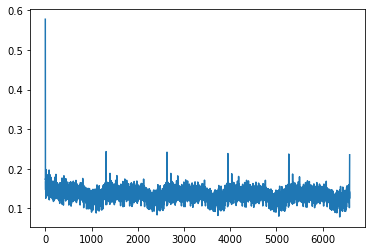

In [105]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(losses))), [l.detach().cpu().item() for l in losses])

In [106]:
enc = enc.eval()
#enc

In [107]:
test_target=pd.read_csv('test_target.csv')
test_target.head()

,id
0,3000000
1,3000001
2,3000002
3,3000003
4,3000004


In [110]:
preds = []
indexes=[]
for x, Id in get_uploaded_tensors(False):
    x = x.to(device)
    score=enc.forward(x)
    sigm = torch.sigmoid(score)
    for pred, _id in zip (np.squeeze(sigm.detach().cpu().numpy()), Id.detach().cpu().numpy()):
        preds.append(pred)
        indexes.append(_id)

In [111]:
pd.DataFrame(data={'id':[int(e) for e in indexes], 'score':preds}).sort_values(by=['id']).to_csv('1_epoch.csv',index=False)

In [55]:
x.shape

torch.Size([257, 10, 59])

In [57]:
Id.shape

torch.Size([257])

In [ ]:
def predict(row):
    X = torch.LongTensor(row[0])
    X = X.to(device)
    lengths = torch.LongTensor([row['lengths']])
    score = enc.forward(X, lengths)
    sigm = torch.sigmoid(score).item()
    del X
    return sigm

In [ ]:
df['score'] = df.apply(lambda row: predict(row), axis=1)

In [ ]:
df['score'].describe()

In [ ]:
df[['id', 'score']].to_csv('1_epoch.csv',index=False)